In [86]:
#  Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
import warnings
warnings.filterwarnings('once')
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [9]:
atm = pd.read_csv('../Caso Datafest/Datafest2024_Train.csv')

In [10]:
def transform_date(date : str):
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    return year + '-' + month + '-' + day

In [11]:
atm['fecha_transaccion'] = atm['fecha_transaccion'].astype('str')

In [12]:
atm['fecha_transaccion'] = atm['fecha_transaccion'].apply(transform_date)

In [13]:
atm['fecha_transaccion'] = pd.to_datetime(atm['fecha_transaccion'])

In [14]:
atm.set_index('fecha_transaccion', inplace = True)

In [15]:
avg_tipo_atm = atm.groupby(['fecha_transaccion', 'tipo_cajero'])['demanda'].mean().reset_index()

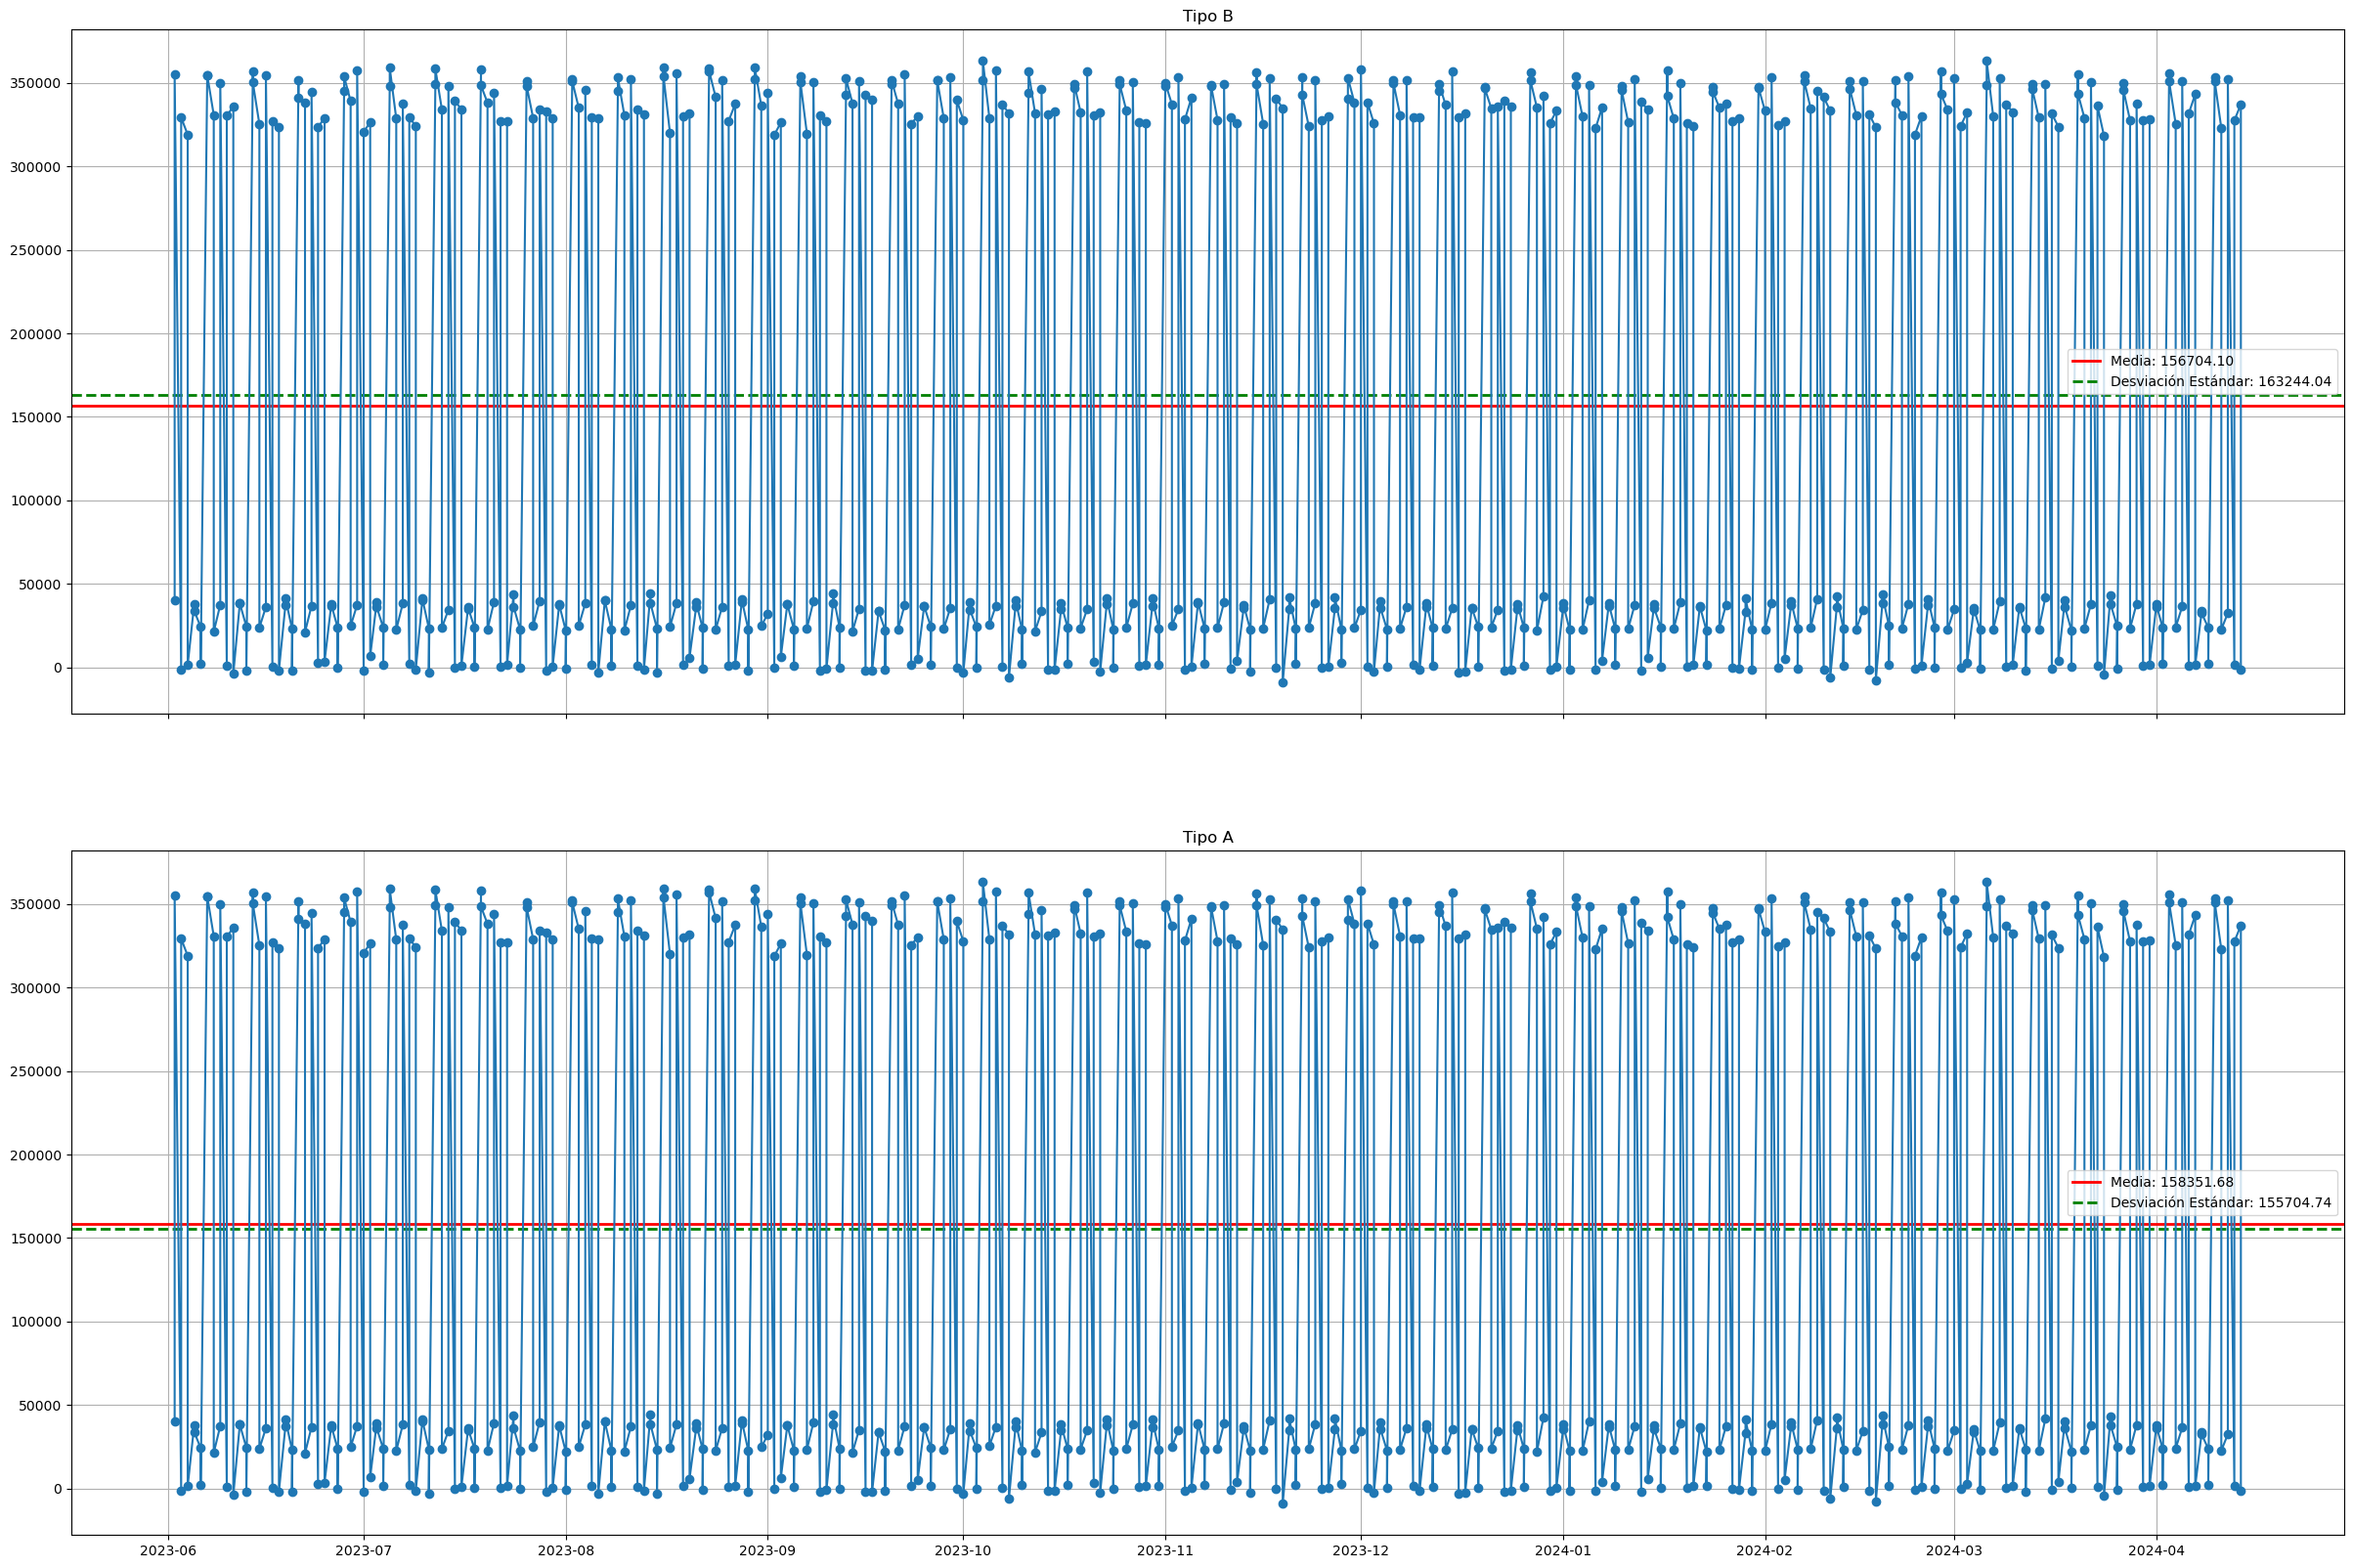

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 20), sharex=True)

for i, category in enumerate(atm['tipo_cajero'].unique()):
    categoria_data = avg_tipo_atm[avg_tipo_atm['tipo_cajero'] == category]
    mean_value = categoria_data['demanda'].mean()
    axes[i].axhline(y=mean_value, color='r', linestyle='-', label=f'Media: {mean_value:.2f}', linewidth = 2)
    std_value = categoria_data['demanda'].std()
    axes[i].axhline(y = std_value, color='g', linestyle='--', label=f'Desviación Estándar: {std_value:.2f}', linewidth = 2)
    axes[i].plot(avg_tipo_atm['fecha_transaccion'], avg_tipo_atm['demanda'], marker='o')
    axes[i].set_title(f'Tipo {category}')
    axes[i].grid(True)
    axes[i].legend()

plt.show()

In [17]:
window_size = 7

In [18]:
avg_tipo_atm['Moving_Average_lag7'] = avg_tipo_atm['demanda'].rolling(window = window_size).mean()

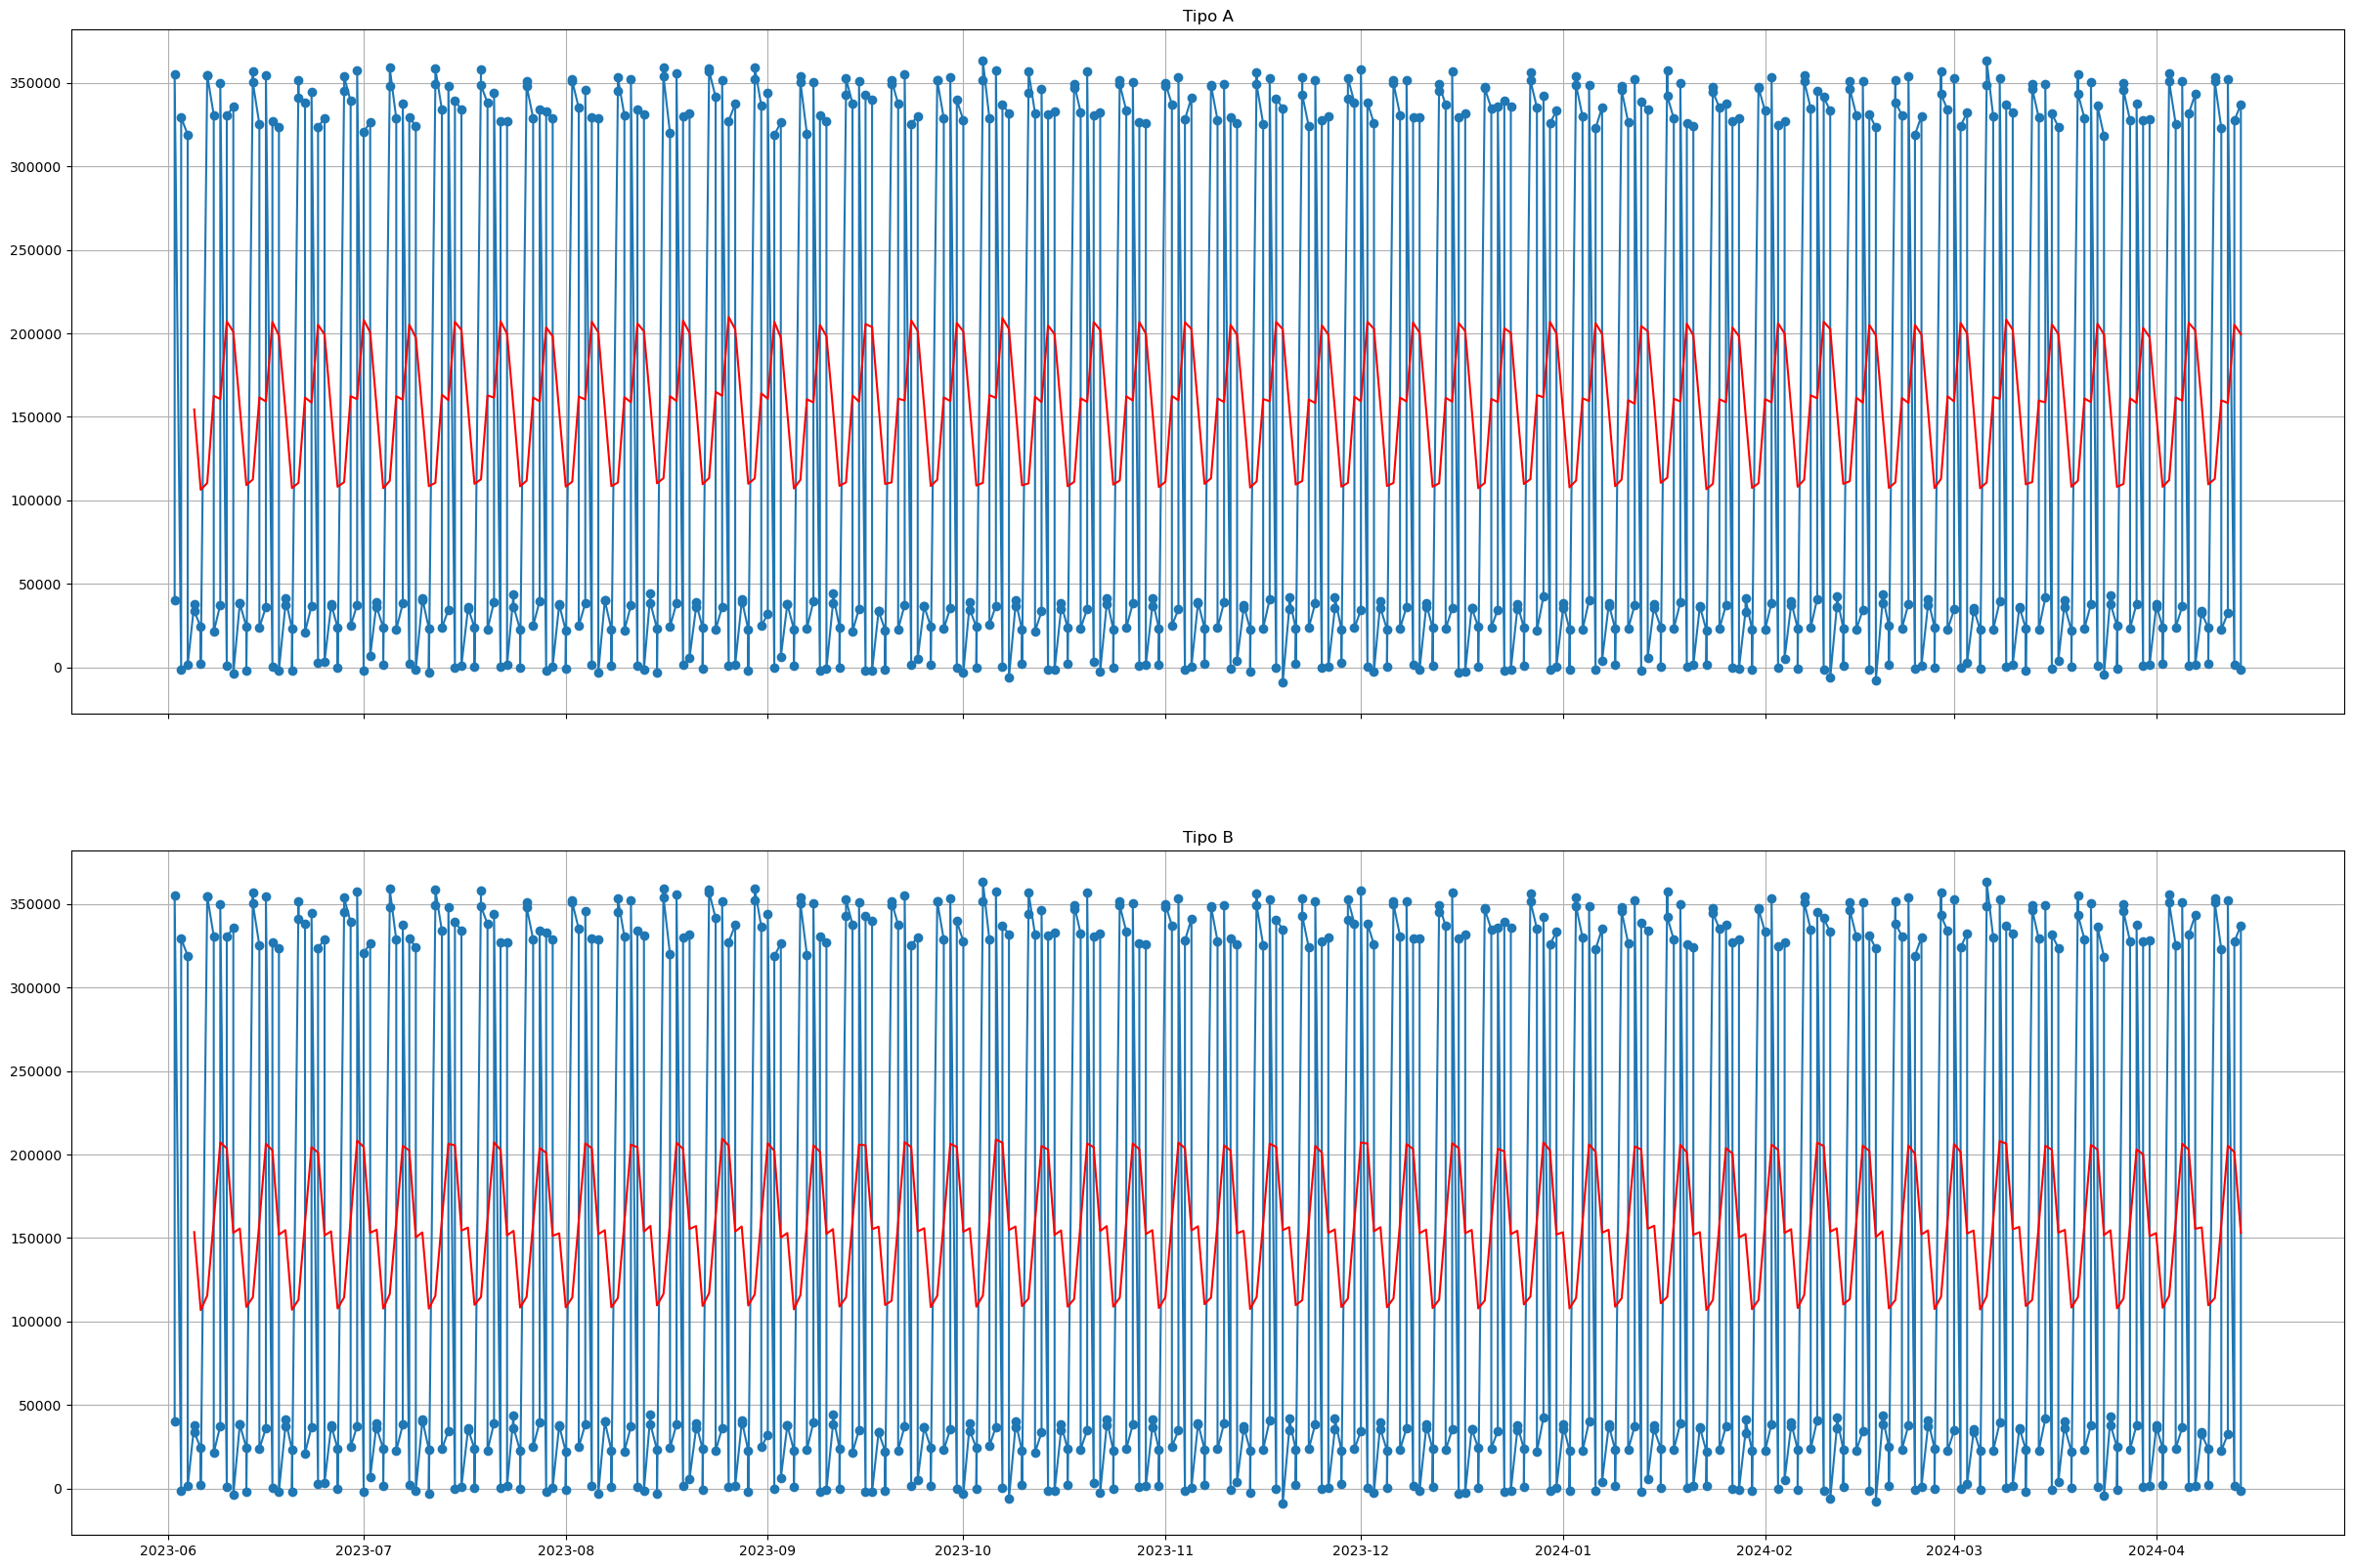

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols=1, figsize=(30, 20), sharex=True)

for i, category in enumerate(avg_tipo_atm['tipo_cajero'].unique()):
    categoria_data = avg_tipo_atm[avg_tipo_atm['tipo_cajero'] == category]
    axes[i].plot(avg_tipo_atm['fecha_transaccion'], avg_tipo_atm['demanda'], marker='o')
    axes[i].plot(categoria_data['fecha_transaccion'], categoria_data['Moving_Average_lag7'], label=f'Media Móvil ({window_size} días)', color='red')
    axes[i].set_title(f'Tipo {category}')
    axes[i].grid(True)

In [20]:
avg_tipo_atm['Moving_std_lag7'] = avg_tipo_atm['demanda'].rolling(window=window_size).std()

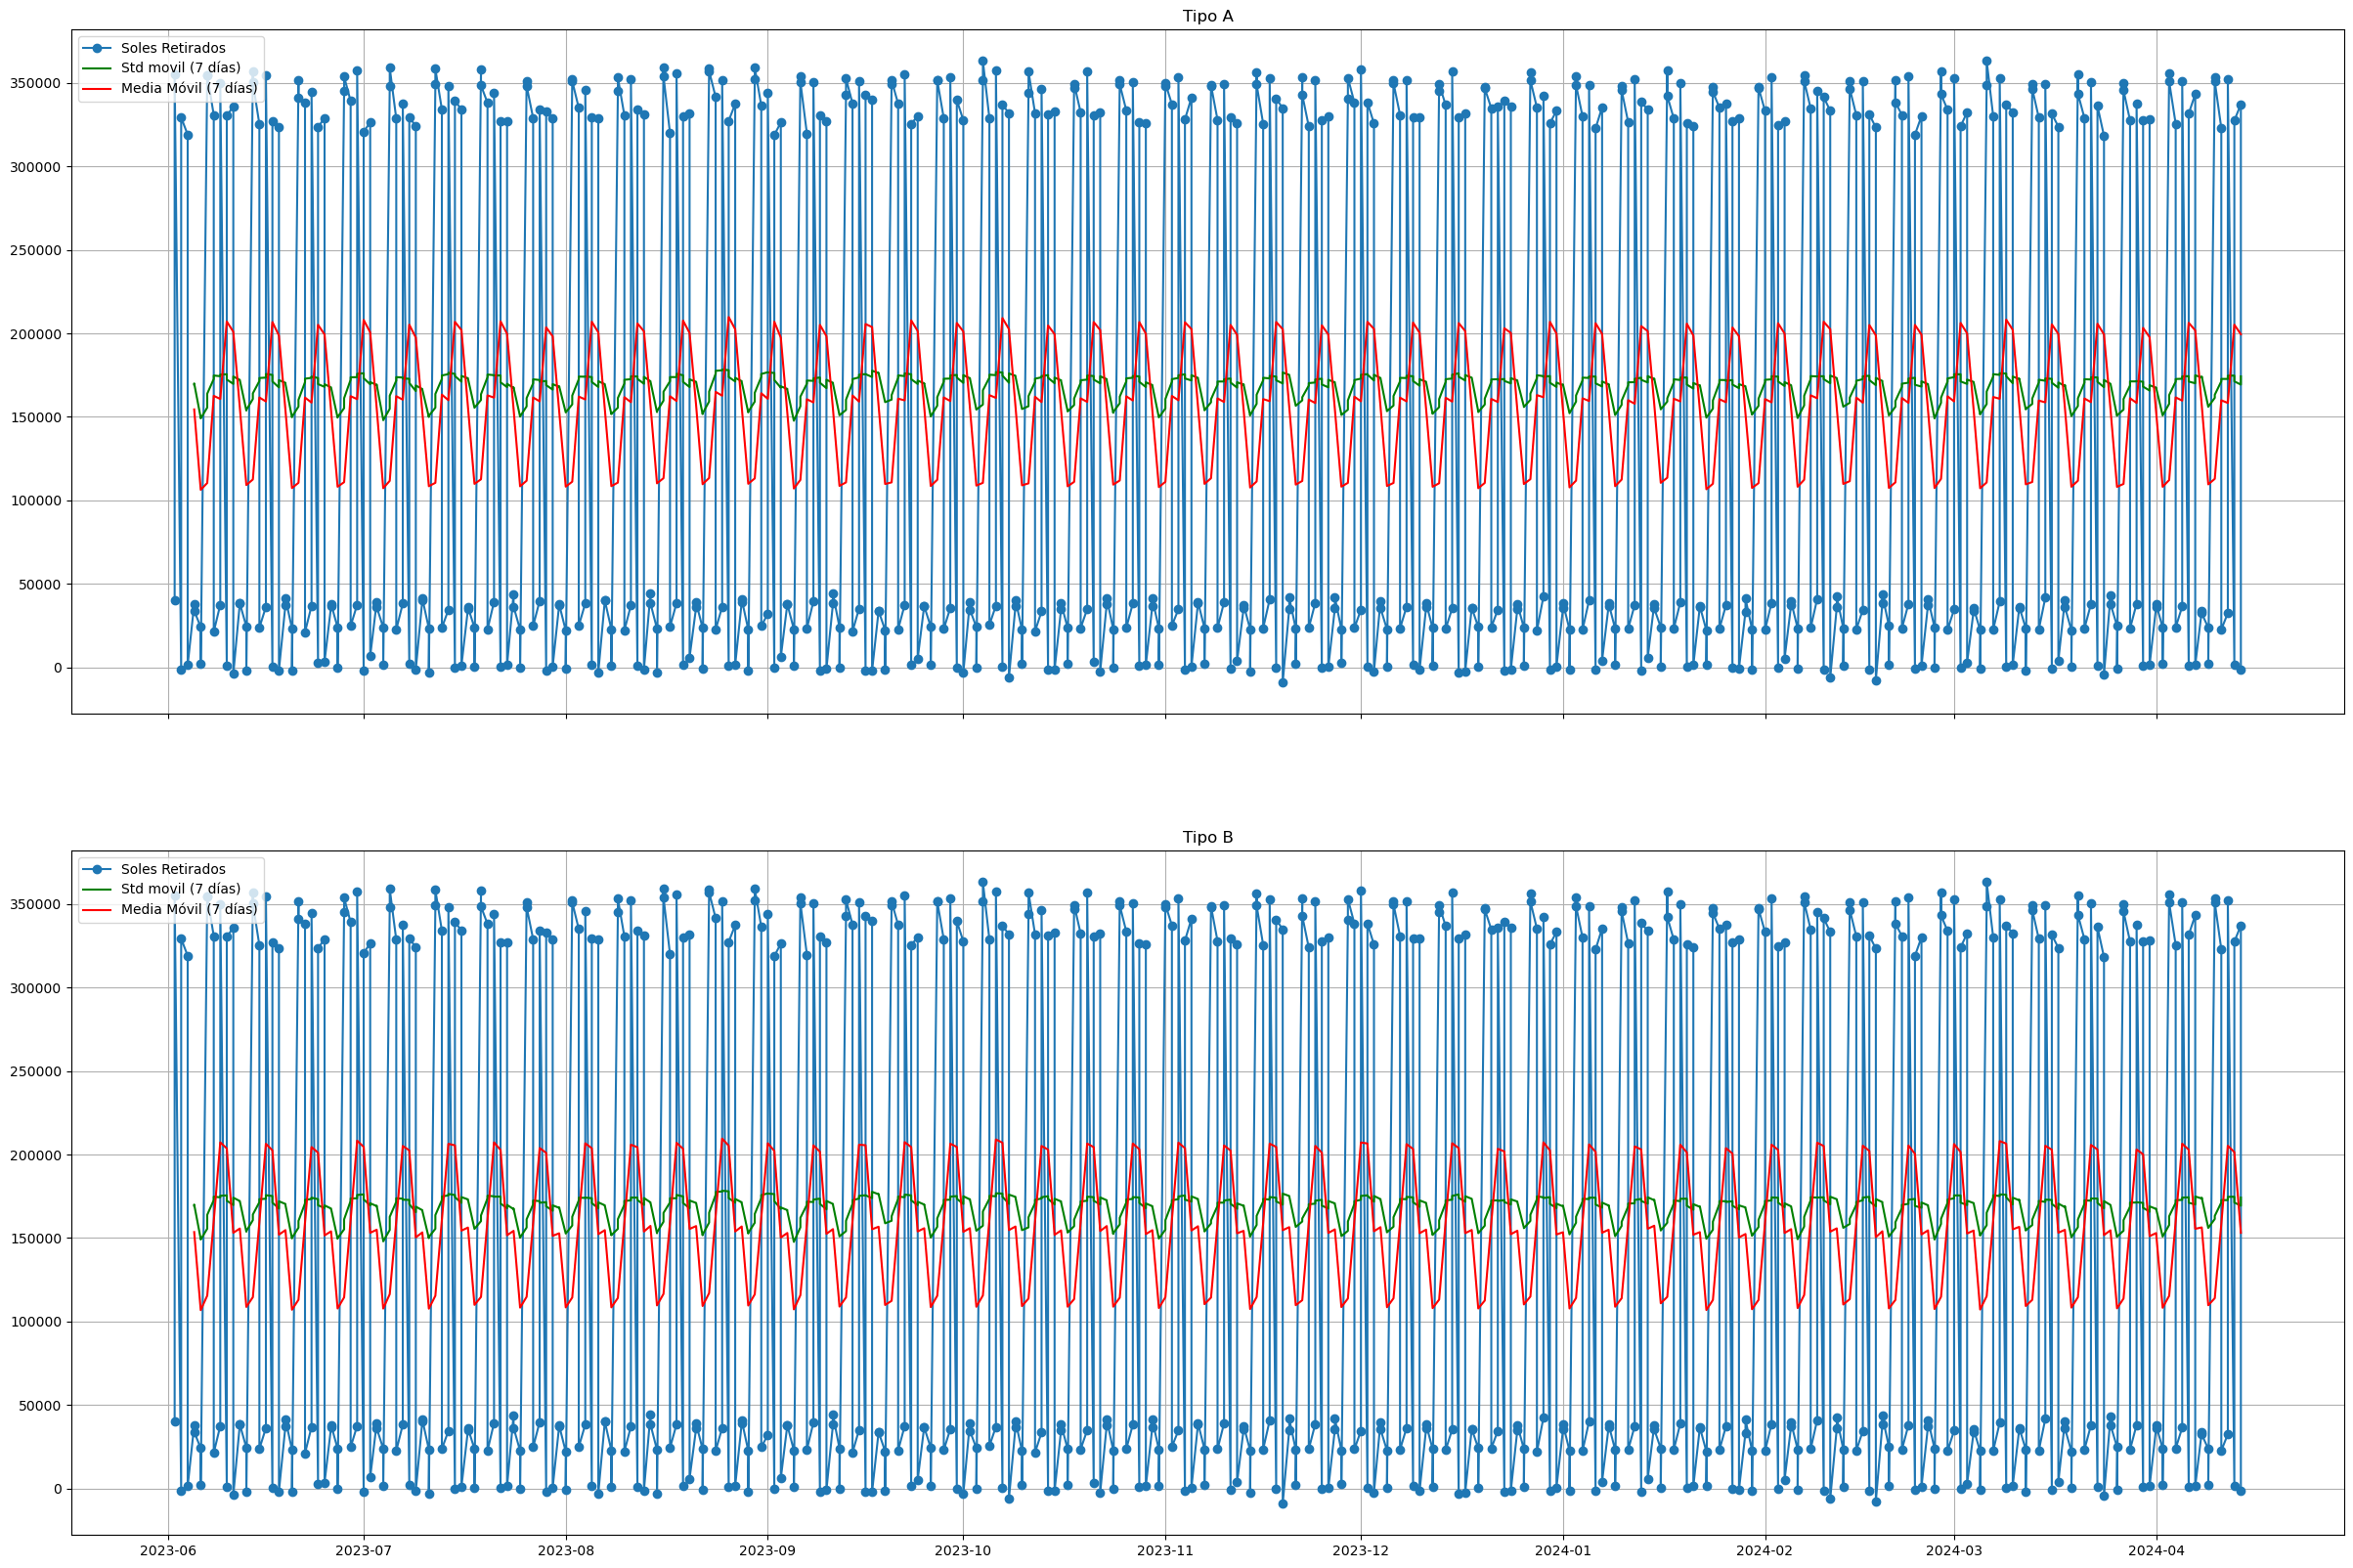

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols=1, figsize=(30, 20), sharex=True)

for i, category in enumerate(avg_tipo_atm['tipo_cajero'].unique()):
    categoria_data = avg_tipo_atm[avg_tipo_atm['tipo_cajero'] == category]
    axes[i].plot(avg_tipo_atm['fecha_transaccion'], avg_tipo_atm['demanda'], marker='o', label='Soles Retirados')
    axes[i].plot(avg_tipo_atm['fecha_transaccion'], avg_tipo_atm['Moving_std_lag7'], label=f'Std movil ({window_size} días)', color='green')
    axes[i].plot(categoria_data['fecha_transaccion'], categoria_data['Moving_Average_lag7'], label=f'Media Móvil ({window_size} días)', color='red')
    axes[i].set_title(f'Tipo {category}')
    axes[i].grid(True)
    axes[i].legend()

plt.show()

# SARIMAX

In [66]:
atm_1 = atm[atm['codigo_cajero'] == 1]

In [67]:
special_days = [15, 30]

In [68]:
atm_1['special_day'] = atm_1.index.day.isin(special_days)

C:\Users\HP\AppData\Local\Temp\ipykernel_17488\2057705466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_1['special_day'] = atm_1.index.day.isin(special_days)


In [69]:
atm_1['special_day'] = atm_1['special_day'].astype(int)

C:\Users\HP\AppData\Local\Temp\ipykernel_17488\499424710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_1['special_day'] = atm_1['special_day'].astype(int)


In [92]:
p = 1    # Orden AR
d = 1    # Diferenciación
q = 1    # Orden MA
P = 1    # Orden AR estacional
D = 1    # Diferenciación estacional
Q = 1    # Orden MA estacional
s = 14    # Periodo estacional (ejemplo: mensual)

# Ajustar el modelo SARIMAX
model = SARIMAX(atm_1['demanda'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s))
results = model.fit()

# Resumen del modelo
print(results.summary())

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            demanda   No. Observations:                  318
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -3889.542
Date:                            Fri, 27 Sep 2024   AIC                           7789.083
Time:                                    23:26:09   BIC                           7807.652
Sample:                                06-02-2023   HQIC                          7796.512
                                     - 04-14-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1370      0.109     -1.256      0.209      -0.351       0.077
ma.L1         -0.8676      0.063   

In [97]:
atm_1

,codigo_cajero,tipo_cajero,saldo_inicial,demanda,abastecimiento,saldo_final,special_day
fecha_transaccion,,,,,,,
2023-06-02,1,B,647830,384630,0,263200,0
2023-06-03,1,B,263200,251860,0,11340,0
2023-06-04,1,B,11340,-52910,0,64250,0
2023-06-05,1,B,64250,24710,357330,396870,0
2023-06-06,1,B,396870,44010,0,352860,0
...,...,...,...,...,...,...,...
2024-04-10,1,B,242040,234980,299460,306520,0
2024-04-11,1,B,306520,32530,290250,564240,0
2024-04-12,1,B,564240,257970,0,306270,0


In [102]:
atm_1.index[int(318*0.8):]

DatetimeIndex(['2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14',
               '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-18',
               '2024-02-19', '2024-02-20', '2024-02-21', '2024-02-22',
               '2024-02-23', '2024-02-24', '2024-02-25', '2024-02-26',
               '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01',
               '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-06',
      

Fechas train : 2023-06-02 00:00:00 --- 2024-02-11 00:00:00 (n=255)
Fechas test : 2024-02-11 00:00:00 --- 2024-04-14 00:00:00 (n=64)


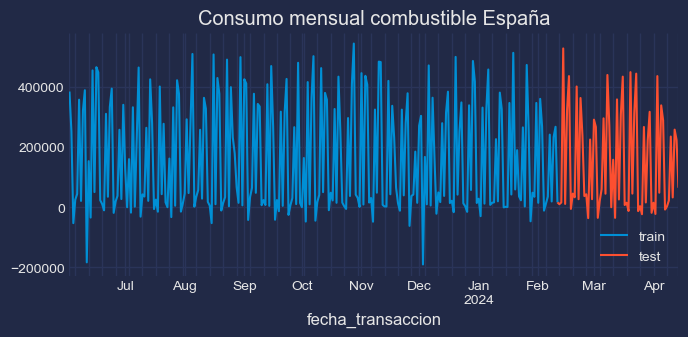

In [107]:
# Fechas Train-test
# ======================================================================================
set_dark_theme()
fin_train = '2024-02-11'
datos = atm_1["demanda"]
print(
 f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()} "
 f"(n={len(datos.loc[:fin_train])})"
)
print(
 f"Fechas test : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()} "
 f"(n={len(datos.loc[fin_train:])})"
)
datos_train = datos.loc[:fin_train]
datos_test = datos.loc[fin_train:]
# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();


Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.629581019768076, p-value: 0.0052200433774515645
KPSS Statistic: 0.22035268370057082, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -8.956906060095466, p-value: 8.426049421010218e-15
KPSS Statistic: 0.2469343299684638, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -9.565403686701451, p-value: 2.3645136056736526e-16
KPSS Statistic: 0.29968595360816946, p-value: 0.1


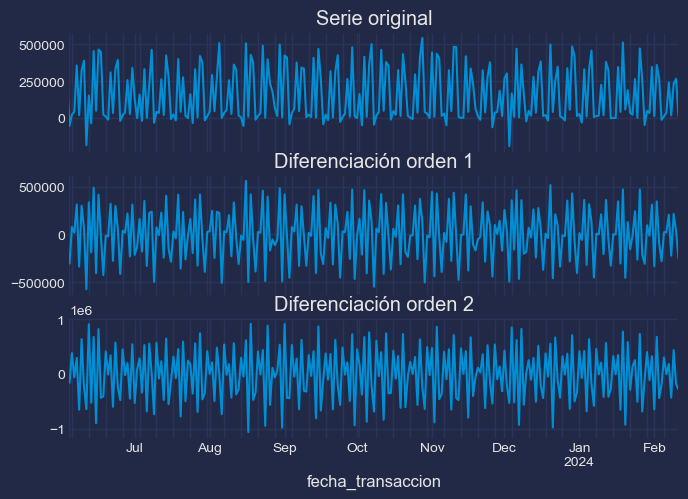

In [108]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")
datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()
print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")
# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

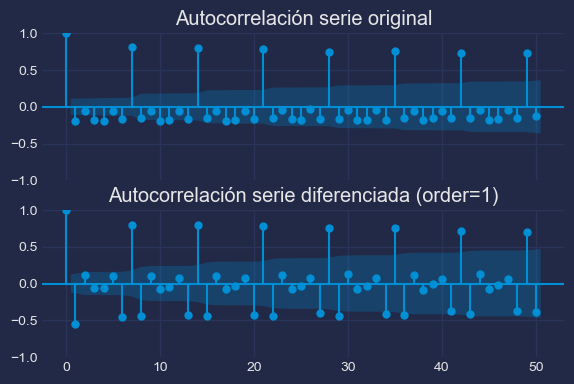

In [109]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

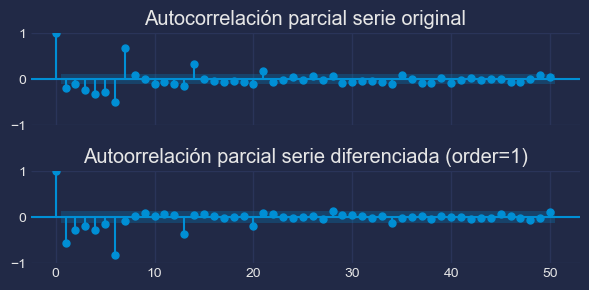

In [111]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

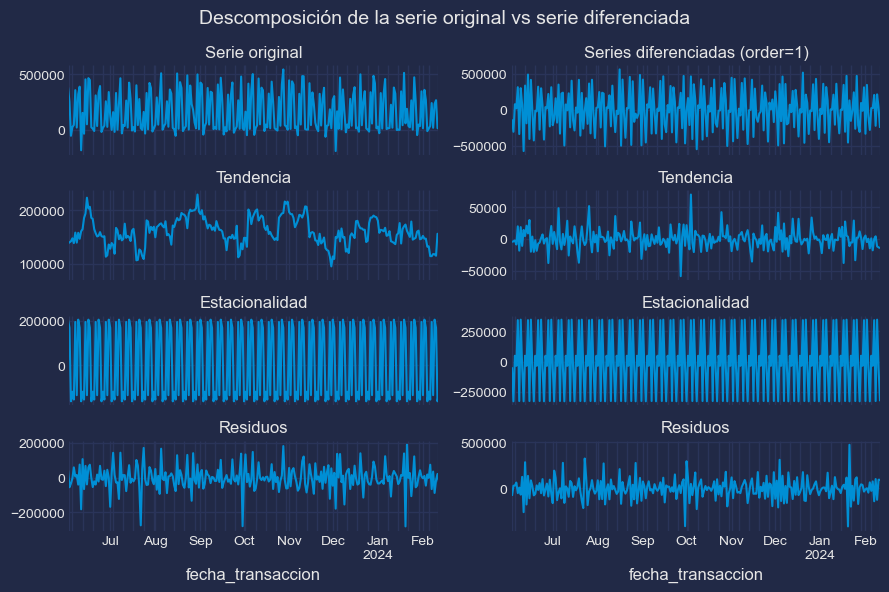

In [112]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [114]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_train.diff().diff(12).dropna()
warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -6.632082131212331, p-value: 5.6816464604665874e-09
KPSS Statistic: 0.4177880212171687, p-value: 0.06948792188915143


# SARIMA

In [115]:
 # Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            demanda   No. Observations:                  255
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3343.172
Date:                            Fri, 27 Sep 2024   AIC                           6696.345
Time:                                    23:39:16   BIC                           6713.789
Sample:                                06-02-2023   HQIC                          6703.372
                                     - 02-11-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1967      0.192     -1.025      0.305      -0.573       0.179
ma.L1         -0.9639      0.103     -9.319      0.000      -1.167      -0.761
ar.S.L12      -0.0947      0.227     -0.417      0.677      -0.540       0.351
ma.S.L12      -0.8545      0.260     -3.288      0.001      -1.364      -0.345
sigma2      1.047e+11   7.01e-13   1.49e+23      0.000    1.05e+11    1.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                21.73
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.41
Prob(H) (two-sided):                  0.31   Kurtosis:                         1.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.96e+38. Standard errors may be unstable.
"""

In [119]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=7).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(15))


2024-02-12    202611.856130
2024-02-13    120699.364412
2024-02-14    182002.273128
2024-02-15    165203.284100
2024-02-16    148952.182854
2024-02-17    163949.241021
2024-02-18    147785.745463
Freq: D, Name: predicciones_statsmodels, dtype: float64

In [121]:
#  Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [122]:
 # Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

,pred
2024-02-12,202611.856130
2024-02-13,120699.364412
2024-02-14,182002.273128
2024-02-15,165203.284100


# pdMarima

In [125]:
 # Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  255
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3349.340
Date:                            Fri, 27 Sep 2024   AIC                           6710.680
Time:                                    23:43:25   BIC                           6731.614
Sample:                                06-02-2023   HQIC                          6719.113
                                     - 02-11-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2265.4439   2499.099     -0.907      0.365   -7163.587    2632.699
ar.L1         -0.2494      0.212     -1.176      0.240      -0.665       0.166
ma.L1         -0.8473      0.190     -4.468      0.000      -1.219      -0.476
ar.S.L12      -0.1561      0.226     -0.692      0.489      -0.598       0.286
ma.S.L12      -0.7840      0.224     -3.494      0.000      -1.224      -0.344
sigma2      1.047e+11   4.26e-06   2.46e+16      0.000    1.05e+11    1.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                19.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.33
Prob(H) (two-sided):                  0.69   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.3e+33. Standard errors may be unstable.
"""

In [126]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))


2024-02-12    144418.789935
2024-02-13     34172.180009
2024-02-14     96821.859680
2024-02-15     76405.703594
Freq: D, Name: predicciones_pdmarima, dtype: float64

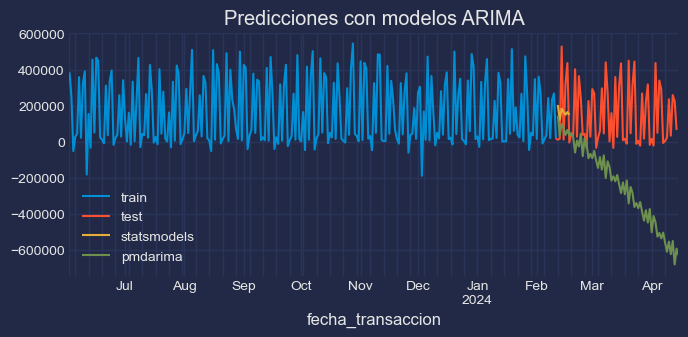

In [128]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
#predicciones_skforecast.columns = ['skforecast']
#predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();


In [129]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
 )
forecaster.fit(y=datos_train, suppress_warnings=True)
# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

c:\Users\HP\miniconda3\envs\Forecasting\lib\site-packages\skforecast\utils\utils.py:1187: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


TypeError: Expected index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> for `last_window`. Got <class 'pandas.core.indexes.range.RangeIndex'>.

In [81]:
datos_test = pd.read_csv('../Caso Datafest/Datafest2024_Test.csv')
datos_test = datos_test[datos_test['codigo_cajero'] == 1]
datos_test['fecha_transaccion'] = datos_test['fecha_transaccion'].astype(str)
datos_test['fecha_transaccion'] = datos_test['fecha_transaccion'].apply(transform_date)
datos_test['fecha_transaccion'] = pd.to_datetime(datos_test['fecha_transaccion'])
datos_test.sort_index(ascending=False, inplace=True)

In [82]:
datos_test

,fecha_transaccion,codigo_cajero,tipo_cajero,saldo_inicial,demanda,abastecimiento,saldo_final
28875,2024-04-15,1,B,17610.0,18020.0,279240.0,278830.0
28175,2024-04-16,1,B,278830.0,-45390.0,0.0,324220.0
27475,2024-04-17,1,B,324220.0,251490.0,333620.0,406350.0
26775,2024-04-18,1,B,406350.0,22690.0,209550.0,593210.0
26075,2024-04-19,1,B,593210.0,350990.0,0.0,242220.0
25375,2024-04-20,1,B,242220.0,195390.0,0.0,46830.0
24675,2024-04-21,1,B,46830.0,16140.0,0.0,30690.0
23975,2024-04-22,1,B,30690.0,16880.0,518440.0,532250.0
23275,2024-04-23,1,B,532250.0,5540.0,0.0,526710.0
22575,2024-04-24,1,B,526710.0,510400.0,217960.0,234270.0


In [83]:
 # Predicción
# ==============================================================================
predicciones_statsmodels = results.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.tail(7))

2024-05-20      1556.026186
2024-05-21    -27803.562643
2024-05-22    310398.120478
2024-05-23     -2421.486120
2024-05-24    308183.049674
2024-05-25    285118.493490
2024-05-26    -26718.584890
Freq: D, Name: predicciones_statsmodels, dtype: float64

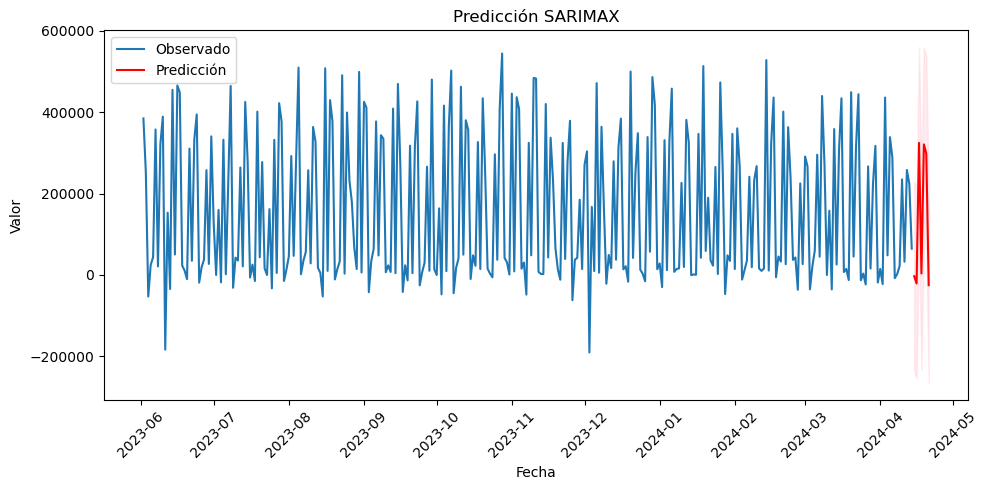

In [73]:
forecast = results.get_forecast(steps=7)
forecast_index = pd.date_range(start=atm_1.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Visualizar predicciones
plt.figure(figsize=(10, 5))
plt.plot(atm_1['demanda'], label='Observado')
plt.plot(forecast_index, forecast_mean, label='Predicción', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Predicción SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño
plt.show()

In [91]:
 # Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
    regressor = Sarimax(
        order = (1, 1, 1),
        seasonal_order = (1, 1, 1, 12),
        maxiter = 200
    )
)

metrica, predicciones = backtesting_sarimax(
    forecaster = forecaster,
    y = atm_1['demanda'],
    initial_train_size = len(atm_1['demanda']),
    fixed_train_size = False,
    steps = 7,
    metric = 'mean_absolute_error',
    refit = True,
    n_jobs = "auto",
    suppress_warnings_fit = True,
    verbose = True,
    show_progress = True
)
display(metrica)
display(predicciones.head(4))

ValueError: If used, `initial_train_size` must be an integer smaller than the length of `y` (318).

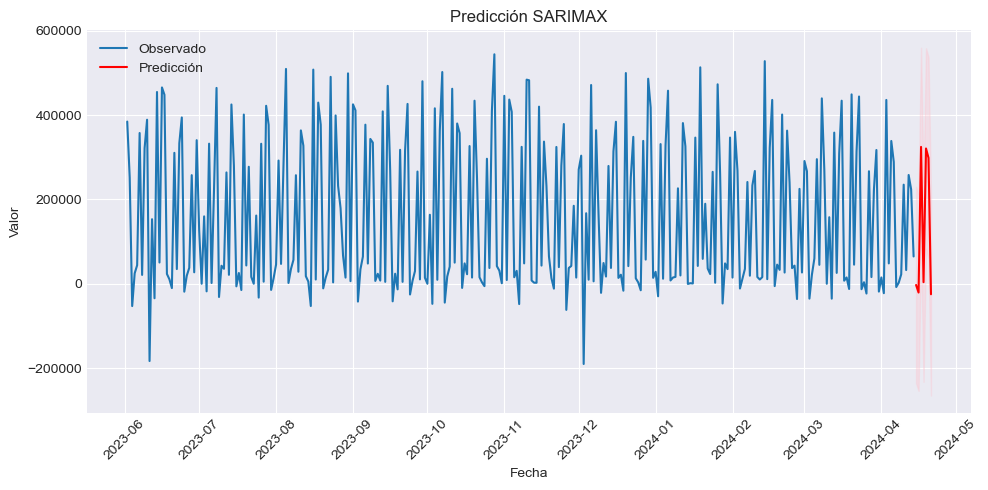

In [87]:
forecast = results.get_forecast(steps=7)
forecast_index = pd.date_range(start=atm_1.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Visualizar predicciones
plt.figure(figsize=(10, 5))
plt.plot(atm_1['demanda'], label='Observado')
plt.plot(forecast_index, forecast_mean, label='Predicción', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Predicción SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño
plt.show()